# Importando as Bibliotecas

In [1]:
import xgboost as xgb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import yeojohnson
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

c:\Users\rodri.RODRIGO\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Tratamento dos dados

In [2]:
# pegando os dados do arquivo
parent_path = os.path.dirname(os.getcwd())
df = pd.read_csv(os.path.join(parent_path, 'data', 'jena_climate_2009_2016.csv'))

df['Date Time'] = pd.to_datetime(df['Date Time'], format="%d.%m.%Y %H:%M:%S")
df.set_index('Date Time', inplace=True)
df = df.drop_duplicates()
df = df.sort_index()
df = df.resample('h').mean()
# Remover Valores Negativos e Nulos
df['wv (m/s)'] = df['wv (m/s)'].apply(lambda x: 0 if x <= 0 else x)
df['max. wv (m/s)'] = df['max. wv (m/s)'].apply(lambda x: 0 if x <= 0 else x)
df = df.dropna()

# Criar DatetimeIndex Completo e Interpolar Valores Faltantes
start_date = df.index.min()
end_date = df.index.max()
hourly_index = pd.date_range(start=start_date, end=end_date, freq='h')
df = df.reindex(hourly_index)
df = df.interpolate(method='time')

# Tratamento de Outliers (Método Simples de IQR)
Q1 = df['T (degC)'].quantile(0.25)
Q3 = df['T (degC)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['T (degC)'] = np.where(df['T (degC)'] < lower_bound, lower_bound, df['T (degC)'])
df['T (degC)'] = np.where(df['T (degC)'] > upper_bound, upper_bound, df['T (degC)'])

# adicionando colunas de data
df["hour"] = df.index.hour
df["dayofyear"] = df.index.dayofyear
df["year"] = df.index.year

In [3]:
# removendo colunas com alta correlação
threshold = 0.8
correlation_matrix = df.corr()
high_corr_pairs = np.where(np.abs(correlation_matrix) > threshold)
high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                   for x, y in zip(*high_corr_pairs) if x != y and x < y]
non_corr_data = df.copy()
for var1, var2 in high_corr_pairs:
    try:
        non_corr_data = non_corr_data.drop(columns=[var2])
    except KeyError:
        pass

In [4]:
# Normalizando os dados
non_corr_data_normalized = non_corr_data.copy()
non_corr_data_normalized['rh (%)'] = yeojohnson(max(non_corr_data_normalized['rh (%)']) - non_corr_data_normalized['rh (%)'])[0]
non_corr_data_normalized['wv (m/s)'] = yeojohnson(np.log(non_corr_data_normalized['wv (m/s)'] + 1e-9))[0]
non_corr_data_normalized['wd (deg)'] = np.sin(2 * np.pi * non_corr_data_normalized['wd (deg)'] / 360)


# Treino e teste do modelo

In [5]:
# preparando para previsão multi-step
lag_hours = 24
forecast_horizon = 24
X_cols = ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)', 'wd (deg)', 'hour', 'dayofyear']
target = 'T (degC)'

X_multi, y_multi, dates_multi = [], [], []
for i in range(len(non_corr_data_normalized) - forecast_horizon):
    X_multi.append(non_corr_data_normalized.iloc[i][X_cols].values)
    y_multi.append(non_corr_data_normalized.iloc[i+1 : i + forecast_horizon+1][target].values)
    dates_multi.append(non_corr_data_normalized.index[i+1 : i + forecast_horizon+1])

X_multi = pd.DataFrame(X_multi, columns=X_cols)
y_multi = pd.DataFrame(y_multi)

In [6]:
# #separando em treino e teste
split_index = len(X_multi) - (24 * 365)
X_train, X_test = X_multi.iloc[:split_index], X_multi.iloc[split_index:]
y_train, y_test = y_multi.iloc[:split_index], y_multi.iloc[split_index:]
test_dates = dates_multi[split_index:]

# normalizando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
#  Hyperparameter Tuning com TimeSeriesSplit e GridSearchCV
print("\nModel Selection and Hyperparameter Tuning (XGBoost MultiOutput):")
param_grid = {
    'estimator__n_estimators': [100, 200, 300], 
    'estimator__learning_rate': [0.01, 0.05, 0.1], 
    'estimator__max_depth': [5, 6, 7]
}
tscv = TimeSeriesSplit(n_splits=3)
base_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=701)
model = MultiOutputRegressor(base_model)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=tscv, verbose=0, n_jobs=-1)

# calculando o número total de avaliações
n_candidates = len(param_grid['estimator__n_estimators']) * \
               len(param_grid['estimator__learning_rate']) * \
               len(param_grid['estimator__max_depth'])
total_evaluations = n_candidates * tscv.get_n_splits(X_train_scaled)

#criação de uma barra de progresso com o tqdm e aplicação do gridsearch
with tqdm_joblib(tqdm(total=total_evaluations, desc="GridSearchCV Fitting")):
    grid_search.fit(X_train_scaled, y_train.values)

best_multioutput_model = grid_search.best_estimator_
print("Best XGBoost MultiOutput model parameters:", grid_search.best_params_)


Model Selection and Hyperparameter Tuning (XGBoost MultiOutput):


GridSearchCV Fitting:   0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Best XGBoost MultiOutput model parameters: {'estimator__learning_rate': 0.05, 'estimator__max_depth': 5, 'estimator__n_estimators': 200}


In [8]:
# Melhor modelo
best_model = best_multioutput_model

# Predição
y_pred = best_model.predict(X_test_scaled)

In [ ]:
# teste
y_pred_flat = y_pred.flatten()
y_test_flat = y_test.values.flatten()

mae = mean_absolute_error(y_test_flat, y_pred_flat)
mse = mean_squared_error(y_test_flat, y_pred_flat)
r2  = r2_score(y_test_flat, y_pred_flat)

print("\nOverall Multi-step Forecast Evaluation (Flattened Predictions):")
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R² Score:", r2)


Overall Multi-step Forecast Evaluation (Flattened Predictions):
Mean Absolute Error: 1.7624130519878813
Mean Squared Error: 5.5507367097436
R² Score: 0.9170103856585549


c:\Users\rodri.RODRIGO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
GridSearchCV Fitting:   0%|          | 0/81 [09:20<?, ?it/s]


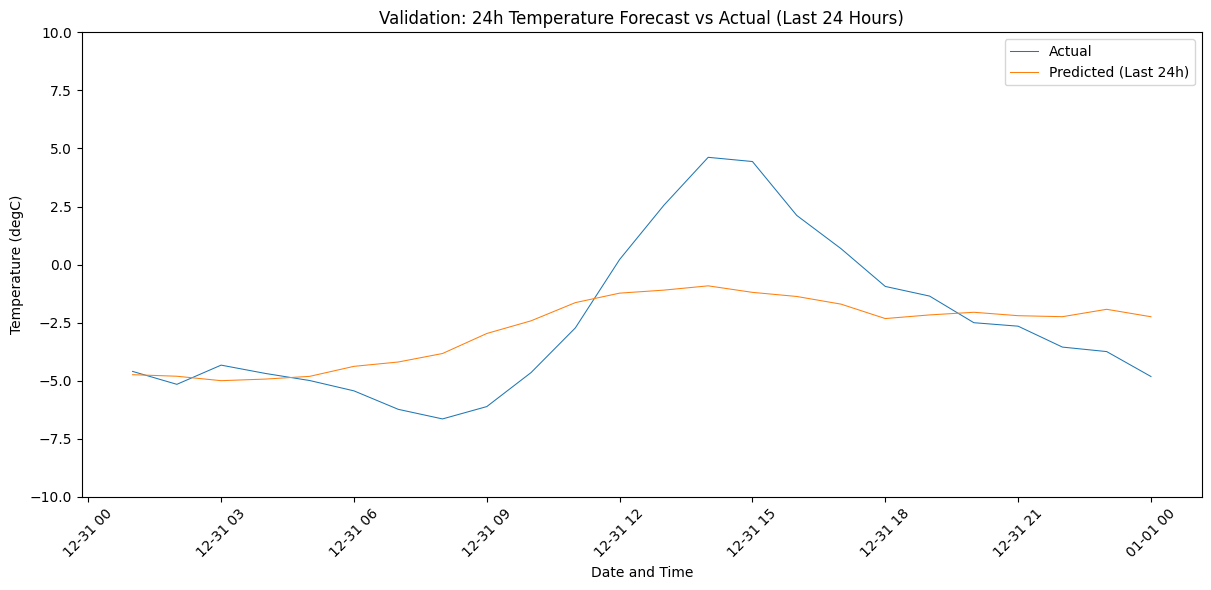

In [ ]:
# Tratando os dados e transformando em um dataframe para facilitar a visualização
X_val = non_corr_data_normalized.iloc[len(non_corr_data_normalized) - 1][X_cols].values.reshape(1, -1)
X_val_scaled = scaler.transform(X_val)
y_val_pred = best_model.predict(X_val_scaled).flatten()
y_val_actual = non_corr_data_normalized.iloc[-forecast_horizon:][target].values
val_dates = non_corr_data_normalized.iloc[-forecast_horizon:].index

# Plotando a previsão das ultimas 24 horas do teste
plt.figure(figsize=(12, 6))
plt.plot(val_dates, y_val_actual, label="Actual", linewidth=0.75)
plt.plot(val_dates, y_val_pred, label="Predicted (Last 24h)", linewidth=0.75)
plt.xlabel("Date and Time")
plt.ylabel("Temperature (degC)")
plt.title("Validation: 24h Temperature Forecast vs Actual (Last 24 Hours)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(-10, 10)
plt.show()

In [11]:
# Metricas de validação
mae_val = mean_absolute_error(y_val_actual, y_val_pred)
mse_val = mean_squared_error(y_val_actual, y_val_pred)
r2_val = r2_score(y_val_actual, y_val_pred)

print("\nValidation Metrics (Last 24h Forecast):")
print("Mean Absolute Error:", mae_val)
print("Mean Squared Error:", mse_val)
print("R² Score:", r2_val)


Validation Metrics (Last 24h Forecast):
Mean Absolute Error: 1.8710466777284942
Mean Squared Error: 5.844900803960615
R² Score: 0.4569467892773025


# Teste da previsão em mais de um periodo

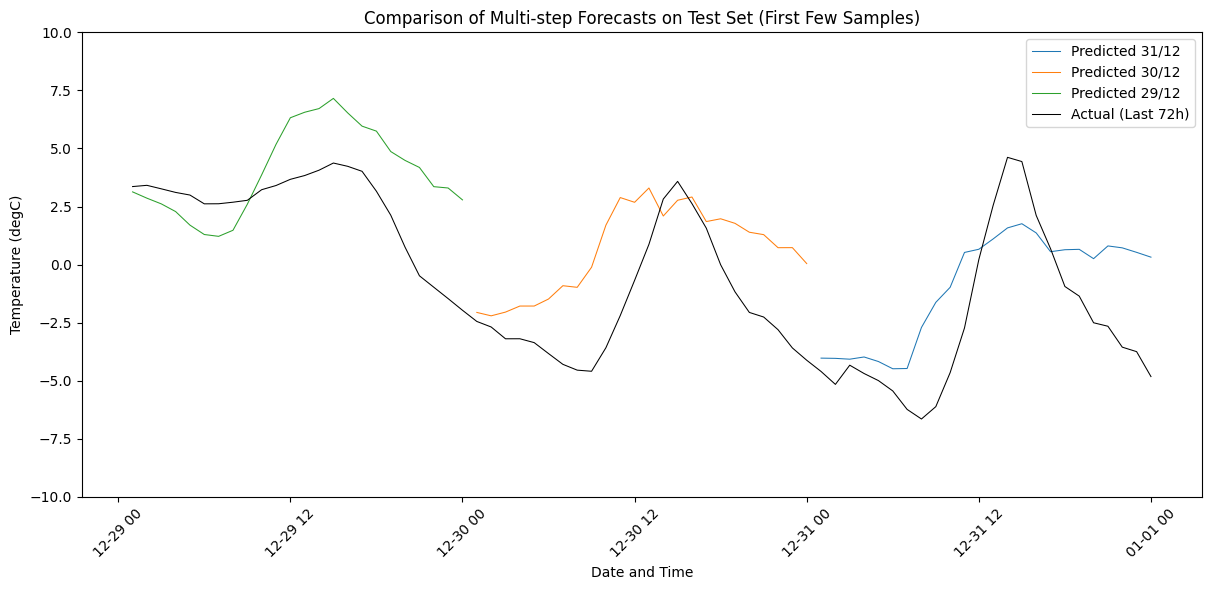

In [ ]:
# Comparação de 3 periodos diferentes
plt.figure(figsize=(12, 6))
num_predictions_to_plot = min(3, len(test_dates))

#loop para prever as ultimas 72 horas
for i in range(num_predictions_to_plot):
    plt.plot(test_dates[-i*24-1], y_pred[-i*24-1], label=f"Predicted {test_dates[-i*24-1][0].strftime('%d/%m')}", linewidth=0.75)

plt.plot(df.index[-72:], df['T (degC)'][-72:], label="Actual (Last 72h)", linewidth=0.75, color='black')
plt.xlabel("Date and Time")
plt.ylabel("Temperature (degC)")
plt.title("Comparison of Multi-step Forecasts on Test Set (First Few Samples)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(-10, 10)
plt.show()

In [13]:
#dataframe com as previsões de todas as horas desde 01/12
forecast_dfs = [
    pd.DataFrame(row, index=test_dates[i], columns=['Predicted_T (degC)'])
    for i, row in enumerate(y_pred)
]


forecast_df = pd.concat(forecast_dfs)

# agrupando as previsões por hora
grouped = forecast_df[-24*31*24:].groupby(forecast_df[-24*31*24:].index)['Predicted_T (degC)']

# calculo de média, intervalo de confiança de 90%
summary_df = grouped.agg(
    mean='mean',
    lower=lambda x: np.percentile(x, 5),
    upper=lambda x: np.percentile(x, 95)
)
summary_df = summary_df[22:]

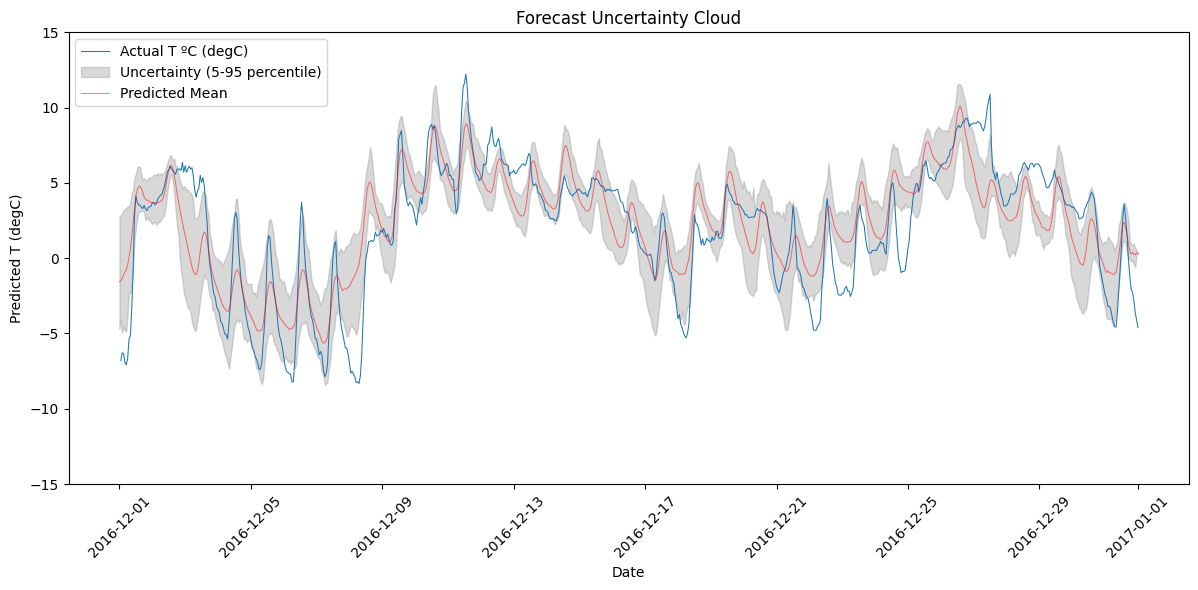

In [16]:
plt.figure(figsize=(12, 6))
# plotando o realizado
plt.plot(df[-24*31:].index, y_test[0][-24*31:], linewidth=0.75, label='Actual T ºC (degC)') 
# fillbetwen para criar a zona de confiança
plt.fill_between(summary_df.index, summary_df['lower'], summary_df['upper'], color='gray', alpha=0.3, label='Uncertainty (5-95 percentile)')
# plotando a média das previsões
plt.plot(summary_df.index, summary_df['mean'], color='red', linewidth=0.75, alpha=0.5, label='Predicted Mean')
plt.xlabel("Date")
plt.ylabel("Predicted T (degC)")
plt.title("Forecast Uncertainty Cloud")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.ylim(-15, 15)
plt.show()

In [15]:
# definindo o periodo de comparação
actual_period = df[-24*31:]  # adjust accordingly

# avaliaçao do modelo com demais métricas
common_index = summary_df.index.intersection(actual_period.index)
y_true = actual_period.loc[common_index, 'T (degC)']
y_pred = summary_df.loc[common_index, 'mean']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)

MAE: 1.8136118861431643
MSE: 4.8295726969280555
R²: 0.7364564367669357
